# Überblick
Dieses Notebook dokumentiert die Erstellung und Evaluierung eines Baseline-Modells zur Umsatzvorhersage für eine Bäckereifiliale. Das Projekt verwendet historische Verkaufsdaten und verschiedene Wetterbedingungen, um zukünftige Umsätze vorherzusagen. Es werden mehrere Modelle getestet, darunter lineare Regression, Ridge Regression und SGD Regressor.

## Verwendete Tools und Bibliotheken
**Pandas:** Datenmanipulation und -analyse

**NumPy:** Numerische Berechnungen

**Matplotlib und Seaborn:** Datenvisualisierung

**Scikit-learn:** Maschinelles Lernen und Modellbewertung

**Statsmodels:** Statistische Modellierung und Analyse

In [226]:
import pandas as pd
import datetime
from sklearn.preprocessing import StandardScaler  # Scaling features for regression
import statsmodels.api as sm  # Building and summarizing regression models
from sklearn.preprocessing import StandardScaler  # Scaling features for regression
import matplotlib.pyplot as plt
import seaborn as sns # Advanced data visualizations
import numpy as np

## Datenvorbereitung

In [227]:
# read prepared data
df_umsatz = pd.read_csv("../0_DataPreparation/Data/model_train_20130701_20180731.csv", parse_dates=['Datum'])
print(df_umsatz.head())

        id      Datum      Umsatz  KielerWoche  weekend_or_holiday  \
0  1307011 2013-07-01  148.828353            0                   0   
1  1307021 2013-07-02  159.793757            0                   0   
2  1307031 2013-07-03  111.885594            0                   0   
3  1307041 2013-07-04  168.864941            0                   0   
4  1307051 2013-07-05  171.280754            0                   0   

   wetter_regen  wetter_schnee  wetter_gewitter  wetter_dunst  wetter_nebel  \
0             0              0                0             0             0   
1             0              0                0             0             0   
2             1              0                0             0             0   
3             0              0                0             0             0   
4             0              0                0             0             0   

   ...  Monat_May  Monat_November  Monat_October  Monat_September  is_Montag  \
0  ...          0       

In [228]:
# Clean up data and drop duplicate columns
"""print(df_umsatz.columns)
columns_to_drop = ["temp_bin_Kalt", "temp_bin_Moderat", "temp_bin_Warm"]
df_umsatz.drop(columns=columns_to_drop, inplace=True)"""
print(df_umsatz.columns)

Index(['id', 'Datum', 'Umsatz', 'KielerWoche', 'weekend_or_holiday',
       'wetter_regen', 'wetter_schnee', 'wetter_gewitter', 'wetter_dunst',
       'wetter_nebel', 'temp_bin_Kalt', 'temp_bin_Moderat', 'temp_bin_Warm',
       'wind_bin_windstill', 'wind_bin_moderat', 'wind_bin_sturm',
       'cloud_Bin_sonnig', 'cloud_Bin_moderat', 'cloud_Bin_bedeckt',
       'is_silvester', 'inflation', 'Warengruppe_Broetchen',
       'Warengruppe_Brot', 'Warengruppe_Croissant', 'Warengruppe_Konditorei',
       'Warengruppe_Kuchen', 'Warengruppe_Saisonbrot', 'Monat_April',
       'Monat_August', 'Monat_December', 'Monat_February', 'Monat_January',
       'Monat_July', 'Monat_June', 'Monat_March', 'Monat_May',
       'Monat_November', 'Monat_October', 'Monat_September', 'is_Montag',
       'is_Dienstag', 'is_Mittwoch', 'is_Donnerstag', 'is_Freitag',
       'is_Samstag'],
      dtype='object')


In [229]:
# Check for missing values
df_umsatz.isna().any()

id                        False
Datum                     False
Umsatz                    False
KielerWoche               False
weekend_or_holiday        False
wetter_regen              False
wetter_schnee             False
wetter_gewitter           False
wetter_dunst              False
wetter_nebel              False
temp_bin_Kalt             False
temp_bin_Moderat          False
temp_bin_Warm             False
wind_bin_windstill        False
wind_bin_moderat          False
wind_bin_sturm            False
cloud_Bin_sonnig          False
cloud_Bin_moderat         False
cloud_Bin_bedeckt         False
is_silvester              False
inflation                 False
Warengruppe_Broetchen     False
Warengruppe_Brot          False
Warengruppe_Croissant     False
Warengruppe_Konditorei    False
Warengruppe_Kuchen        False
Warengruppe_Saisonbrot    False
Monat_April               False
Monat_August              False
Monat_December            False
Monat_February            False
Monat_Ja

In [230]:
# select features and target variable
features = [i for i in df_umsatz.columns if i not in ["id","Datum","Umsatz"]]
X = df_umsatz[features]
Y = df_umsatz["Umsatz"]
# Scale the 'inflation' column to standardize the range
scaler = StandardScaler()
df_umsatz['inflation'] = scaler.fit_transform(df_umsatz[['inflation']])
print(df_umsatz.head())


        id      Datum      Umsatz  KielerWoche  weekend_or_holiday  \
0  1307011 2013-07-01  148.828353            0                   0   
1  1307021 2013-07-02  159.793757            0                   0   
2  1307031 2013-07-03  111.885594            0                   0   
3  1307041 2013-07-04  168.864941            0                   0   
4  1307051 2013-07-05  171.280754            0                   0   

   wetter_regen  wetter_schnee  wetter_gewitter  wetter_dunst  wetter_nebel  \
0             0              0                0             0             0   
1             0              0                0             0             0   
2             1              0                0             0             0   
3             0              0                0             0             0   
4             0              0                0             0             0   

   ...  Monat_May  Monat_November  Monat_October  Monat_September  is_Montag  \
0  ...          0       

In [231]:
# Convert the 'Datum' column to datetime
df_umsatz['Datum'] = pd.to_datetime(df_umsatz['Datum'])

# Split the DataFrame into test and train data
df_umsatz_train = df_umsatz[df_umsatz['Datum'] <= '2017-07-31']
df_umsatz_test = df_umsatz[(df_umsatz['Datum'] > '2017-07-31') & (df_umsatz['Datum'] <= '2018-07-31')]
df_umsatz_test = df_umsatz_test.reset_index(drop=True)
df_umsatz_train

,id,Datum,Umsatz,KielerWoche,weekend_or_holiday,wetter_regen,wetter_schnee,wetter_gewitter,wetter_dunst,wetter_nebel,...,Monat_May,Monat_November,Monat_October,Monat_September,is_Montag,is_Dienstag,is_Mittwoch,is_Donnerstag,is_Freitag,is_Samstag
0,1307011,2013-07-01,148.828353,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1,1307021,2013-07-02,159.793757,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,1307031,2013-07-03,111.885594,0,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,1307041,2013-07-04,168.864941,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,1307051,2013-07-05,171.280754,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9273,1612226,2016-12-22,54.322960,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
9274,1612236,2016-12-23,133.499200,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
9275,1612246,2016-12-24,39.577538,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
9276,1612276,2016-12-27,48.890718,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [232]:
df_umsatz_test

,id,Datum,Umsatz,KielerWoche,weekend_or_holiday,wetter_regen,wetter_schnee,wetter_gewitter,wetter_dunst,wetter_nebel,...,Monat_May,Monat_November,Monat_October,Monat_September,is_Montag,is_Dienstag,is_Mittwoch,is_Donnerstag,is_Freitag,is_Samstag
0,1708011,2017-08-01,166.135486,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1,1708021,2017-08-02,155.022099,0,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,1708031,2017-08-03,159.575340,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
3,1708041,2017-08-04,161.585239,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,1708051,2017-08-05,198.088094,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1836,1712216,2017-12-21,87.471228,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1837,1712226,2017-12-22,71.911652,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
1838,1712236,2017-12-23,84.062223,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1839,1712246,2017-12-24,60.981969,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [233]:
# Add constant to test set for predictions
X_test = sm.add_constant(df_umsatz_test[features], has_constant='add')  
X_test

,const,KielerWoche,weekend_or_holiday,wetter_regen,wetter_schnee,wetter_gewitter,wetter_dunst,wetter_nebel,temp_bin_Kalt,temp_bin_Moderat,...,Monat_May,Monat_November,Monat_October,Monat_September,is_Montag,is_Dienstag,is_Mittwoch,is_Donnerstag,is_Freitag,is_Samstag
0,1.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1,1.0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,1.0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,1.0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
4,1.0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1836,1.0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
1837,1.0,0,0,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,1,0
1838,1.0,0,1,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
1839,1.0,0,1,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [234]:
X_train = sm.add_constant(df_umsatz_train[features])
X_train

,const,KielerWoche,weekend_or_holiday,wetter_regen,wetter_schnee,wetter_gewitter,wetter_dunst,wetter_nebel,temp_bin_Kalt,temp_bin_Moderat,...,Monat_May,Monat_November,Monat_October,Monat_September,is_Montag,is_Dienstag,is_Mittwoch,is_Donnerstag,is_Freitag,is_Samstag
0,1.0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0
1,1.0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
2,1.0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,1.0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
4,1.0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9273,1.0,0,0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
9274,1.0,0,0,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,1,0
9275,1.0,0,1,0,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
9276,1.0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0


## Modellierung und Evaluierung

In [235]:
# Train the linear regression model using Statsmodels
model = sm.OLS(df_umsatz_train["Umsatz"], X_train).fit()

# Print the summary of the regression model
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:                 Umsatz   R-squared:                       0.762
Model:                            OLS   Adj. R-squared:                  0.760
Method:                 Least Squares   F-statistic:                     643.5
Date:                Sat, 08 Feb 2025   Prob (F-statistic):               0.00
Time:                        12:15:03   Log-Likelihood:                -42693.
No. Observations:                7493   AIC:                         8.546e+04
Df Residuals:                    7455   BIC:                         8.573e+04
Df Model:                          37                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                     65

In [236]:
# Make predictions on the test set
predictions = model.predict(X_test)
print("Predictions for test data:", predictions)

Predictions for test data: 0       187.429802
1       186.205281
2       184.739946
3       193.847781
4       240.034096
           ...    
1836     51.342222
1837     64.474606
1838     99.146465
1839    107.255261
1840     46.449511
Length: 1841, dtype: float64


In [237]:
# Calculate Mean Absolute Percentage Error (MAPE) for error evaluation
mape = (abs((df_umsatz_test["Umsatz"] - predictions) / df_umsatz_test["Umsatz"]).mean()) * 100
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")

Mean Absolute Percentage Error (MAPE): 33.57%


/tmp/ipykernel_2742/3071136976.py:4: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([df_umsatz_test.Umsatz.min(), df_umsatz_test.Umsatz.max()], [df_umsatz_test.Umsatz.min(), df_umsatz_test.Umsatz.max()], 'k--', color="red")


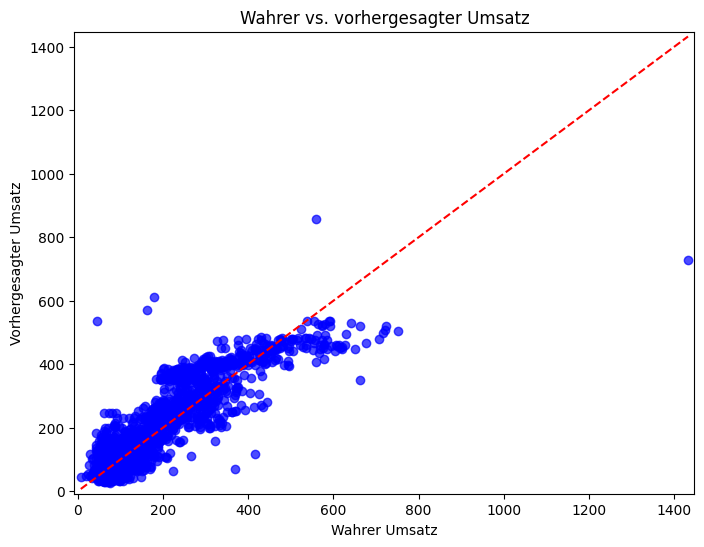

In [238]:
# Scatter plot: Actual vs. Predicted Prices
plt.figure(figsize=(8, 6))
plt.scatter(df_umsatz_test.Umsatz, predictions, alpha=0.7, color="blue")
plt.plot([df_umsatz_test.Umsatz.min(), df_umsatz_test.Umsatz.max()], [df_umsatz_test.Umsatz.min(), df_umsatz_test.Umsatz.max()], 'k--', color="red")

plt.xlim([df_umsatz_test.Umsatz.min()-15, df_umsatz_test.Umsatz.max()+15])
plt.ylim([df_umsatz_test.Umsatz.min()-15, df_umsatz_test.Umsatz.max()+15])

plt.xlabel("Wahrer Umsatz")
plt.ylabel("Vorhergesagter Umsatz")
plt.title("Wahrer vs. vorhergesagter Umsatz")
plt.show()

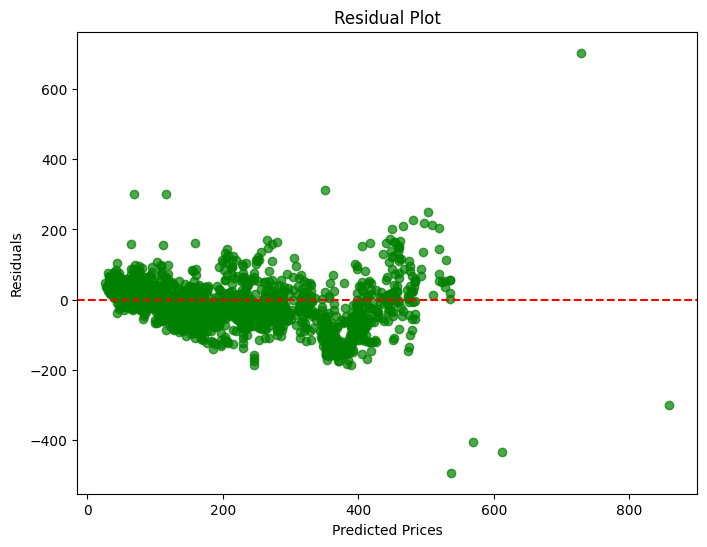

In [239]:
# Calculate residuals (differences between actual and predicted values)
residuals = df_umsatz_test["Umsatz"] - predictions

# Residual plot: Predicted Prices vs. Residuals
plt.figure(figsize=(8, 6))
plt.scatter(predictions, residuals, alpha=0.7, color="green")
plt.axhline(y=0, color="red", linestyle="--")
plt.xlabel("Predicted Prices")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.show()

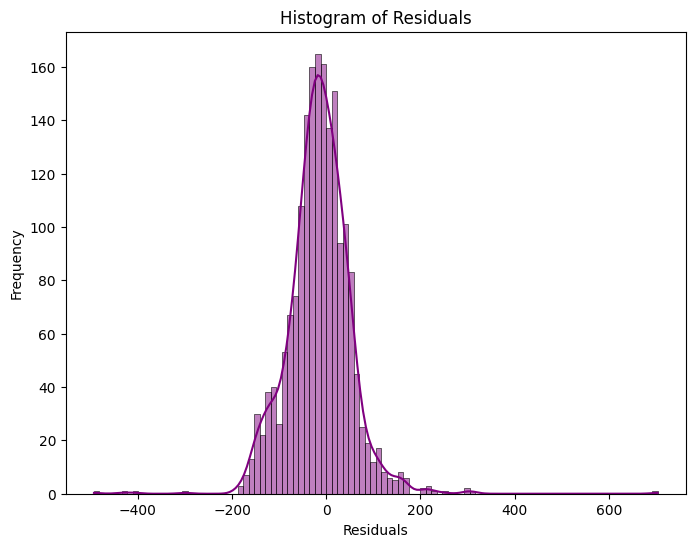

In [240]:
# Histogram of residuals to check normality
plt.figure(figsize=(8, 6))
sns.histplot(residuals, kde=True, color="purple")
plt.title("Histogram of Residuals")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.show()

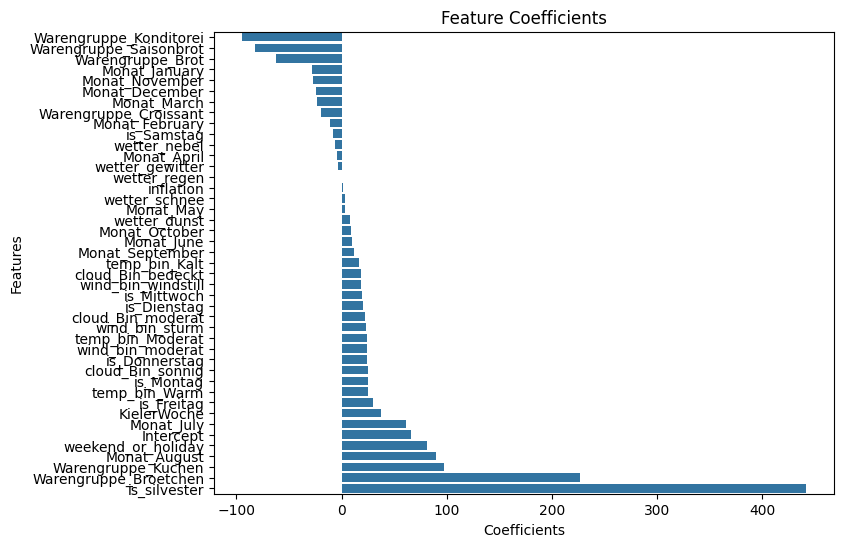

In [241]:
# Create a DataFrame of model coefficients
coefficients = pd.DataFrame({
    'Feature': ['Intercept'] + features,
    'Coefficient': model.params
})

# Bar plot of feature coefficients
plt.figure(figsize=(8, 6))
sns.barplot(x='Coefficient', y='Feature', data=coefficients.sort_values('Coefficient', ascending=True))
plt.title("Feature Coefficients")
plt.xlabel("Coefficients")
plt.ylabel("Features")
plt.show()

## Experimenting with different Models

### Ridge Regression with Hyperparameter Tuning

In [242]:
# Import necessary libraries
import pandas as pd  # For data manipulation
from sklearn.model_selection import train_test_split, GridSearchCV  # Train-test split and hyperparameter tuning
from sklearn.linear_model import Ridge  # Ridge Regression model
from sklearn.metrics import mean_absolute_error, mean_squared_error  # Evaluation metrics)

In [243]:
# Add a constant term to the training data for the regression intercept
X_train = sm.add_constant(df_umsatz_train[features])
y_train = df_umsatz_train["Umsatz"]

# Initialize Ridge Regression model
ridge = Ridge()

# Define hyperparameter grid for alpha (regularization strength)
param_grid = {
    'alpha': [0.01, 0.1, 1, 10, 40, 50, 100, 200]  # Testing a range of regularization strengths
}

# Create a GridSearchCV object for hyperparameter tuning
grid_search = GridSearchCV(estimator=ridge, param_grid=param_grid, cv=5, scoring='neg_mean_absolute_error', verbose=1)

# Train Ridge Regression model using GridSearchCV
grid_search.fit(X_train, y_train)

# Output the best hyperparameters from the grid search
print("Best Hyperparameters:", grid_search.best_params_)

# Retrieve the best model from the grid search
best_model = grid_search.best_estimator_

# Make predictions on the test set
predictions2 = best_model.predict(X_test)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best Hyperparameters: {'alpha': 50}


In [244]:
# Calculate error metrics
mae = mean_absolute_error(df_umsatz_test["Umsatz"], predictions2)  # Mean Absolute Error
mse = mean_squared_error(df_umsatz_test["Umsatz"], predictions2)  # Mean Squared Error
mape = (abs((df_umsatz_test["Umsatz"] - predictions2) / df_umsatz_test["Umsatz"]).mean()) * 100  # Mean Absolute Percentage Error

# Output evaluation metrics
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")

Mean Absolute Error (MAE): 48.47
Mean Squared Error (MSE): 4592.93
Mean Absolute Percentage Error (MAPE): 33.05%


In [245]:
from sklearn.metrics import r2_score

def calc_adj_r2(y_true, y_pred, n_features):
    n = len(y_true)
    r2 = r2_score(y_true, y_pred)
    adj_r2 = 1 - ((1-r2)*(n-1)/(n-n_features-1))
    return adj_r2

# Berechne adjusted R² für Ridge Model
y_pred = best_model.predict(X_test)
adj_r2 = calc_adj_r2(df_umsatz_test["Umsatz"], y_pred, len(features))
print(f"Adjusted R² für Ridge Model: {adj_r2:.4f}")

Adjusted R² für Ridge Model: 0.7222


/tmp/ipykernel_2742/1494559498.py:4: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([df_umsatz_test.Umsatz.min(), df_umsatz_test.Umsatz.max()], [df_umsatz_test.Umsatz.min(), df_umsatz_test.Umsatz.max()], 'k--', color="red")


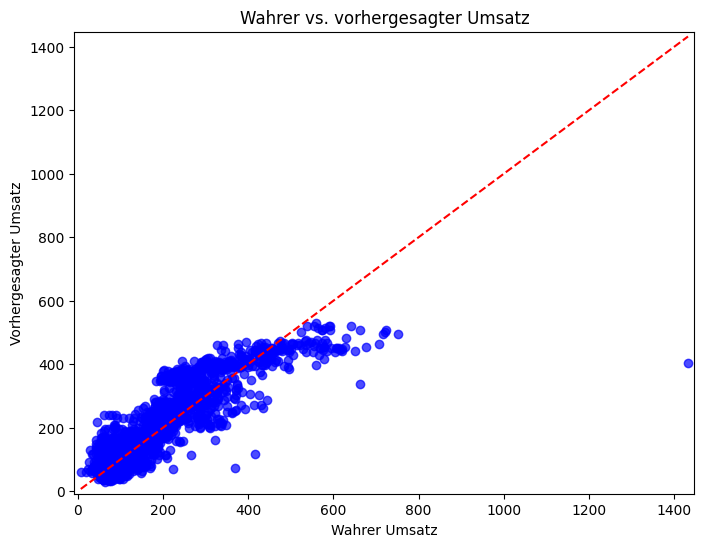

In [246]:
# Scatter plot: Actual vs. Predicted Prices
plt.figure(figsize=(8, 6))
plt.scatter(df_umsatz_test.Umsatz, predictions2, alpha=0.7, color="blue")
plt.plot([df_umsatz_test.Umsatz.min(), df_umsatz_test.Umsatz.max()], [df_umsatz_test.Umsatz.min(), df_umsatz_test.Umsatz.max()], 'k--', color="red")

plt.xlim([df_umsatz_test.Umsatz.min()-15, df_umsatz_test.Umsatz.max()+15])
plt.ylim([df_umsatz_test.Umsatz.min()-15, df_umsatz_test.Umsatz.max()+15])

plt.xlabel("Wahrer Umsatz")
plt.ylabel("Vorhergesagter Umsatz")
plt.title("Wahrer vs. vorhergesagter Umsatz")
plt.show()

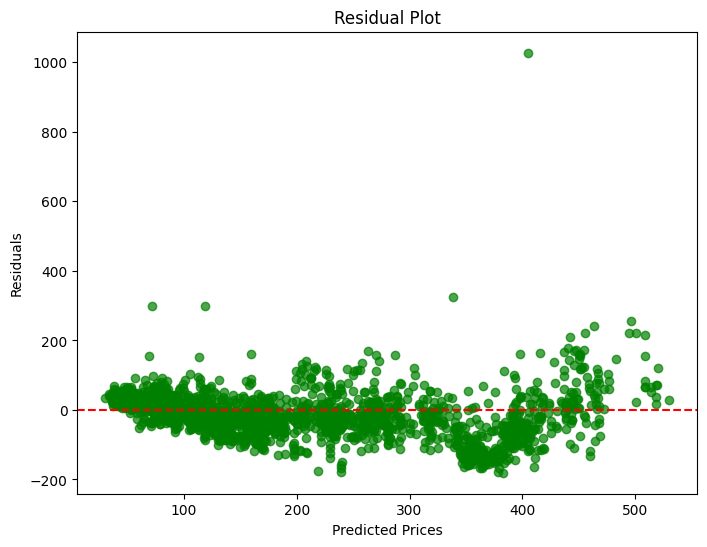

In [247]:
# Calculate residuals (differences between actual and predicted values)
residuals2 = df_umsatz_test["Umsatz"] - predictions2

# Residual plot: Predicted Prices vs. Residuals
plt.figure(figsize=(8, 6))
plt.scatter(predictions2, residuals2, alpha=0.7, color="green")
plt.axhline(y=0, color="red", linestyle="--")
plt.xlabel("Predicted Prices")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.show()

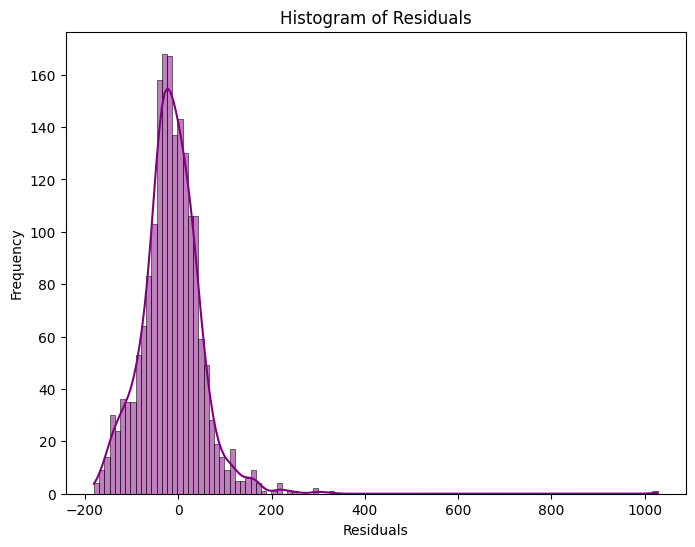

In [248]:
# Histogram of residuals to check normality
plt.figure(figsize=(8, 6))
sns.histplot(residuals2, kde=True, color="purple")
plt.title("Histogram of Residuals")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.show()

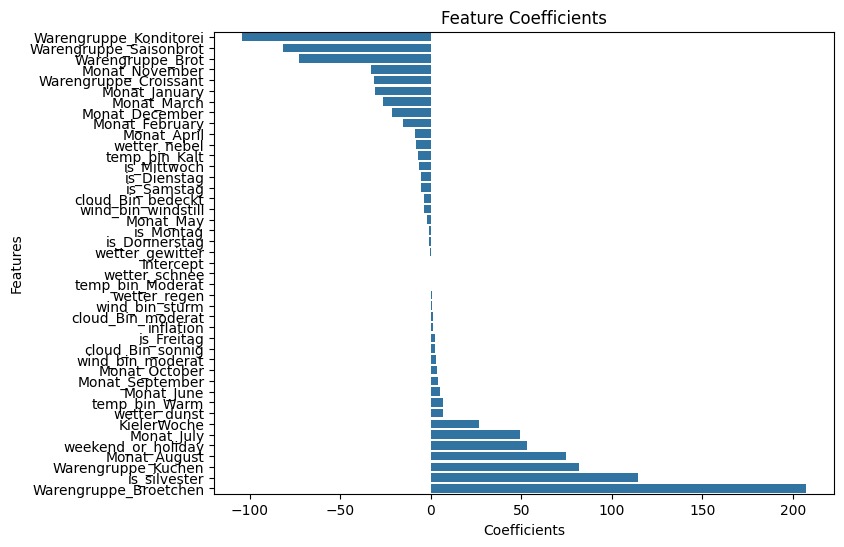

In [249]:
# Create a DataFrame of model coefficients
coefficients_ridge = pd.DataFrame({
    'Feature': ['Intercept'] + features,
    'Coefficient': best_model.coef_
})

# Bar plot of feature coefficients
plt.figure(figsize=(8, 6))
sns.barplot(x='Coefficient', y='Feature', data=coefficients_ridge.sort_values('Coefficient', ascending=True))
plt.title("Feature Coefficients")
plt.xlabel("Coefficients")
plt.ylabel("Features")
plt.show()

### SGD Regressor

In [250]:
# Import necessary libraries
from sklearn.linear_model import SGDRegressor  # Stochastic Gradient Descent Regressor
from sklearn.metrics import mean_absolute_error, mean_squared_error  # Evaluation metrics
import pandas as pd  # Data manipulation
import matplotlib.pyplot as plt  # Visualization
import seaborn as sns  # Advanced visualizations
from sklearn.model_selection import train_test_split  # Splitting data into train and test sets

In [251]:
# Train a Stochastic Gradient Descent (SGD) Regressor
# Parameters:
# - max_iter: Maximum number of iterations for training.
# - learning_rate: Type of learning rate schedule ('invscaling' decreases learning rate over time).
# - eta0: Initial learning rate.
sgd_model = SGDRegressor(max_iter=1000, learning_rate='invscaling', eta0=0.01, random_state=42, alpha=0.001, penalty='l2')
sgd_model.fit(X_train, y_train)

# Make predictions on the test set
sgd_predictions = sgd_model.predict(X_test)
print("Predictions for test data:", sgd_predictions[:5])  # Display first 5 predictions

Predictions for test data: [183.84135302 182.77048289 181.51984882 188.08440499 236.72025536]


In [252]:
# Calculate error metrics
mae = mean_absolute_error(df_umsatz_test["Umsatz"], sgd_predictions)  # Mean Absolute Error
mse = mean_squared_error(df_umsatz_test["Umsatz"], sgd_predictions)  # Mean Squared Error
mape = (abs((df_umsatz_test["Umsatz"] - sgd_predictions) / df_umsatz_test["Umsatz"]).mean()) * 100  # Mean Absolute Percentage Error

# Print error metrics
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")


Mean Absolute Error (MAE): 48.55
Mean Squared Error (MSE): 4566.11
Mean Absolute Percentage Error (MAPE): 32.39%


In [253]:
def calc_adj_r2(y_true, y_pred, n_features):
    n = len(y_true)
    r2 = r2_score(y_true, y_pred)
    adj_r2 = 1 - ((1-r2)*(n-1)/(n-n_features-1))
    return adj_r2

# Berechne adjusted R² für SGD Model
y_pred = sgd_model.predict(X_test)
adj_r2 = calc_adj_r2(df_umsatz_test["Umsatz"], y_pred, len(features))
print(f"Adjusted R² für SGD Model: {adj_r2:.4f}")

Adjusted R² für SGD Model: 0.7238


/tmp/ipykernel_2742/2586506805.py:4: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([df_umsatz_test["Umsatz"].min(), df_umsatz_test["Umsatz"].max()], [df_umsatz_test["Umsatz"].min(), df_umsatz_test["Umsatz"].max()], 'k--', color="red")


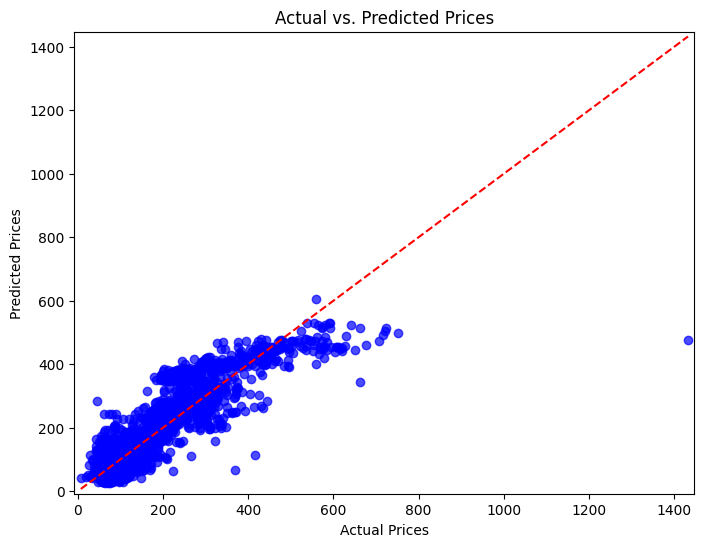

In [254]:
# Plot: Actual vs. Predicted Prices
plt.figure(figsize=(8, 6))
plt.scatter(df_umsatz_test["Umsatz"], sgd_predictions, alpha=0.7, color="blue")
plt.plot([df_umsatz_test["Umsatz"].min(), df_umsatz_test["Umsatz"].max()], [df_umsatz_test["Umsatz"].min(), df_umsatz_test["Umsatz"].max()], 'k--', color="red")
plt.xlabel("Actual Prices")
plt.ylabel("Predicted Prices")
plt.title("Actual vs. Predicted Prices")
plt.xlim([df_umsatz_test.Umsatz.min()-15, df_umsatz_test.Umsatz.max()+15])
plt.ylim([df_umsatz_test.Umsatz.min()-15, df_umsatz_test.Umsatz.max()+15])
plt.show()

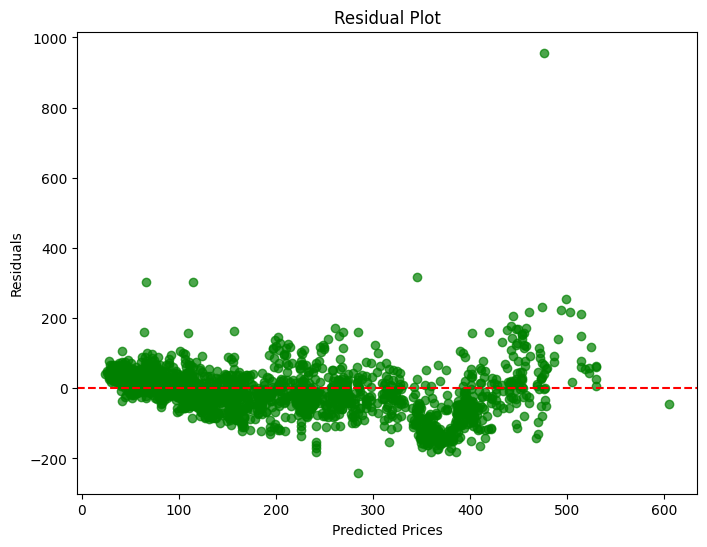

In [255]:

# Calculate residuals (differences between actual and predicted values)
residuals = df_umsatz_test["Umsatz"] - sgd_predictions

# Residual plot: Predicted Prices vs. Residuals
plt.figure(figsize=(8, 6))
plt.scatter(sgd_predictions, residuals, alpha=0.7, color="green")
plt.axhline(y=0, color="red", linestyle="--")
plt.xlabel("Predicted Prices")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.show()

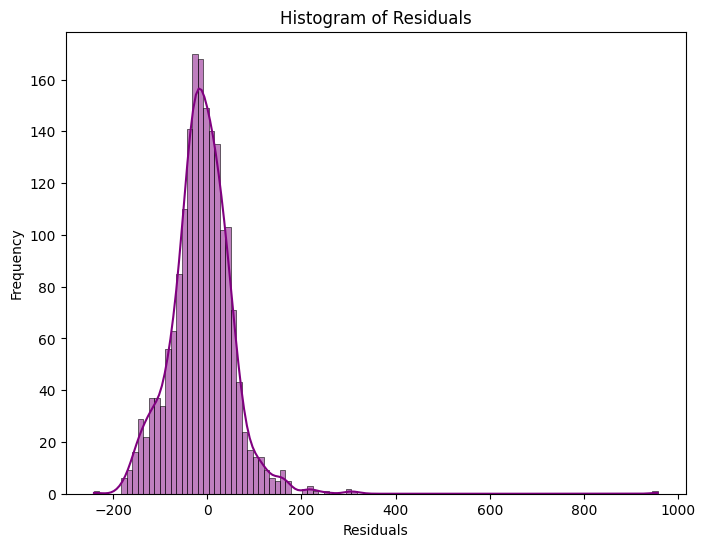

In [256]:
# Histogram of residuals to check distribution
plt.figure(figsize=(8, 6))
sns.histplot(residuals, kde=True, color="purple")
plt.title("Histogram of Residuals")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.show()

Shape-Überprüfung:
Features shape: 42
Coefficients shape: (43,)


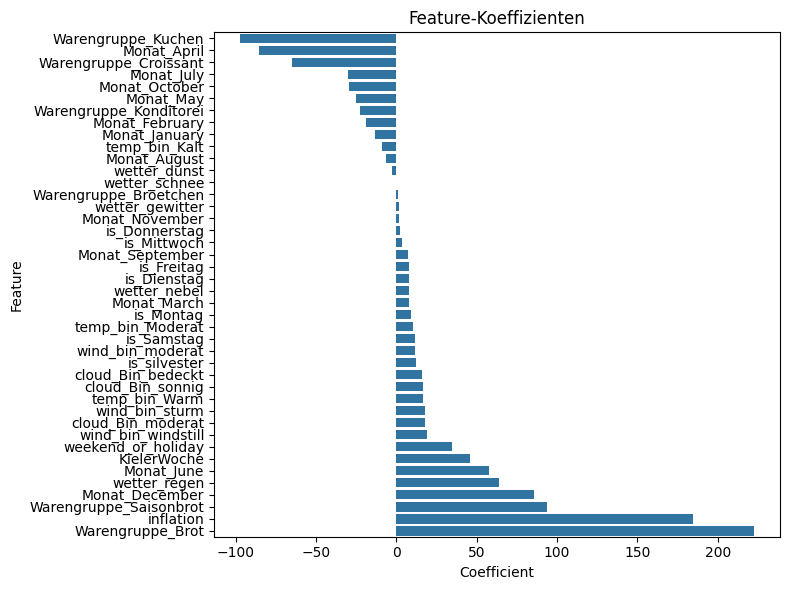

In [257]:
# Debug-Informationen
print("Shape-Überprüfung:")
print(f"Features shape: {len(features)}")
print(f"Coefficients shape: {sgd_model.coef_.shape}")

# Koeffizienten richtig extrahieren
if len(sgd_model.coef_.shape) > 1:
    coefficients_array = sgd_model.coef_.ravel()  # Flatten falls mehrdimensional
else:
    coefficients_array = sgd_model.coef_

# DataFrame mit übereinstimmenden Längen erstellen
coefficients_sgd = pd.DataFrame({
    'Feature': features[:len(coefficients_array)],
    'Coefficient': coefficients_array[:len(features)]
})

# Visualisierung
plt.figure(figsize=(8, 6))
sns.barplot(data=coefficients_sgd.sort_values('Coefficient', ascending=True), 
            y='Feature', 
            x='Coefficient')
plt.title('Feature-Koeffizienten')
plt.tight_layout()
plt.show()